In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.8/882.8 kB 12.8 MB/s eta 0:00:00


In [ ]:
pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: santhoshkim
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


100%|██████████| 149M/149M [00:00<00:00, 190MB/s]


In [ ]:
!pip install dill



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 1.4 MB/s eta 0:00:00


In [ ]:
import torch
import cv2
from PIL import Image
import numpy as np
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from google.colab.patches import cv2_imshow

YOLO Classes: {0: 'Glioma', 1: 'Meningioma', 2: 'No-Tumor', 3: 'Pituitary'}

0: 640x640 1 Glioma, 313.6ms
Speed: 4.7ms preprocess, 313.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Detected Tumor Type: kit_fox with confidence 0.84


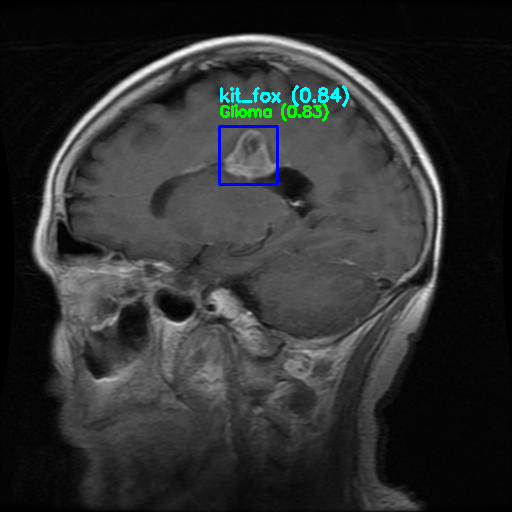

In [ ]:
import torch
import cv2
from PIL import Image
import numpy as np
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from google.colab.patches import cv2_imshow  # For displaying images in Colab

# Load YOLOv10 model using custom weights
from ultralytics import YOLO

dirnameYolo = "/content/braintumor.pt"
yolo_model = YOLO(dirnameYolo)

# Get class names for the YOLO model
class_list = yolo_model.model.names
print("YOLO Classes:", class_list)

# Load ResNet152V2 model for classification
#resnet_model = ResNet152V2(weights='imagenet')
custom_weights_path = '/content/brain_tumor_detector.h5'
resnet_model = ResNet152V2(weights=None)
resnet_model.load_weights(custom_weights_path)
# Function to detect tumors using YOLOv10
def detect_tumor(image_path):
    image = Image.open(image_path).convert('RGB')
    results = yolo_model(image)
    # Extract bounding boxes, scores, and classes
    detections = []
    for box in results[0].boxes:  # Loop through each box
        x_min, y_min, x_max, y_max = box.xyxy[0].cpu().numpy()
        conf = box.conf[0].cpu().numpy()  # Confidence score
        cls = box.cls[0].cpu().numpy()  # Class label (index)
        detections.append((x_min, y_min, x_max, y_max, conf, cls))

    return np.array(detections), np.array(image)

# Function to classify the tumor region using ResNet152V2
def classify_tumor_region(img_array):
    img = Image.fromarray(img_array)  # Convert array back to PIL image for resizing
    img = img.resize((224, 224))  # Resize to ResNet input size
    img = keras_image.img_to_array(img)  # Convert to NumPy array
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)  # Preprocess for ResNet model

    # Predict the class using ResNet152V2
    predictions = resnet_model.predict(img)
    return decode_predictions(predictions, top=1)[0]  # Get top-1 prediction

# Function to visualize detection results
def visualize_detections(image, detections):
    for det in detections:
        x_min, y_min, x_max, y_max, conf, cls = det  # Unpack detection
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])  # Convert to int

        # Draw rectangle around detected region
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        # Annotate the detection with confidence score and class label
        label = f'{class_list[int(cls)]} ({conf:.2f})'  # Get class name from index
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display image in Colab
    cv2_imshow(image)
    cv2.waitKey(0)

# Main function to process the MRI image
def process_image(image_path):
    detections, original_image = detect_tumor(image_path)  # Detect tumors using YOLOv10

    # Loop through detected regions and classify each
    for det in detections:
        x_min, y_min, x_max, y_max = map(int, det[:4])
        cropped_region = original_image[y_min:y_max, x_min:x_max]  # Crop detected region

        # Classify the cropped region using ResNet152V2
        tumor_type = classify_tumor_region(cropped_region)
        print(f"Detected Tumor Type: {tumor_type[0][1]} with confidence {tumor_type[0][2]:.2f}")

        # Annotate the classification result on the image
        cv2.putText(original_image, f'{tumor_type[0][1]} ({tumor_type[0][2]:.2f})',
                    (x_min, y_min - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    # Visualize the final results with annotations
    visualize_detections(original_image, detections)

# Example usage
image_path = '/content/brain-tumor-mri-dataset/Training/glioma/Tr-gl_0045.jpg'
process_image(image_path)
